In [ ]:
First, download the library and dependencies that you will need to run this lab.

In [1]:
import pandas as pd # import library to read data into dataframe
pd.set_option("display.max_columns", None)
import numpy as np # import numpy library
import re # import library for regular expression
import random # library for random number generation

In [ ]:
import aiohttp
import asyncio

async def download(url, filename):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            if response.status == 200:
                with open(filename, "wb") as f:
                    #print(type(response.content))
                    f.write(await response.content.read())
            # return await response.bytes()
    #response = await pyfetch(url)
    #if response.status == 200:
    #    with open(filename, "wb") as f:
    #        f.write(await response.bytes())
 
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0103EN-SkillsNetwork/labs/Module%202/recipes.csv"
 
#you will need to download the dataset; if you are running locally, please comment out the following 
await download(path, "recipes.csv")

We already placed the data on an IBM server for your convenience, so download the data from the server and read the data into a dataframe called **recipes**.

In [2]:
recipes = pd.read_csv("recipes.csv")

print("Data read into dataframe!") # takes about 30 seconds

Data read into dataframe!


> Note: This version of the lab is working on JupyterLite, which requires the dataset to be downloaded to the interface.While working on the downloaded version of this notebook on their local machines(Jupyter Anaconda), the learners can simply **skip the steps above,** and simply use the URL directly in the `pandas.read_csv()` function. You can uncomment and run the statements in the cell below.

Next, repeat the preprocessing steps that you implemented in the lab **From Understanding to Preparation** to prepare the data for modeling. For more details on preparing the data, please refer to the Lab **From Understanding to Preparation**.

In [3]:
# fix name of the column displaying the cuisine
column_names = recipes.columns.values
column_names[0] = "cuisine"
recipes.columns = column_names

# convert cuisine names to lower case
recipes["cuisine"] = recipes["cuisine"].str.lower()

# make the cuisine names consistent
recipes.loc[recipes["cuisine"] == "austria", "cuisine"] = "austrian"
recipes.loc[recipes["cuisine"] == "belgium", "cuisine"] = "belgian"
recipes.loc[recipes["cuisine"] == "china", "cuisine"] = "chinese"
recipes.loc[recipes["cuisine"] == "canada", "cuisine"] = "canadian"
recipes.loc[recipes["cuisine"] == "netherlands", "cuisine"] = "dutch"
recipes.loc[recipes["cuisine"] == "france", "cuisine"] = "french"
recipes.loc[recipes["cuisine"] == "germany", "cuisine"] = "german"
recipes.loc[recipes["cuisine"] == "india", "cuisine"] = "indian"
recipes.loc[recipes["cuisine"] == "indonesia", "cuisine"] = "indonesian"
recipes.loc[recipes["cuisine"] == "iran", "cuisine"] = "iranian"
recipes.loc[recipes["cuisine"] == "italy", "cuisine"] = "italian"
recipes.loc[recipes["cuisine"] == "japan", "cuisine"] = "japanese"
recipes.loc[recipes["cuisine"] == "israel", "cuisine"] = "jewish"
recipes.loc[recipes["cuisine"] == "korea", "cuisine"] = "korean"
recipes.loc[recipes["cuisine"] == "lebanon", "cuisine"] = "lebanese"
recipes.loc[recipes["cuisine"] == "malaysia", "cuisine"] = "malaysian"
recipes.loc[recipes["cuisine"] == "mexico", "cuisine"] = "mexican"
recipes.loc[recipes["cuisine"] == "pakistan", "cuisine"] = "pakistani"
recipes.loc[recipes["cuisine"] == "philippines", "cuisine"] = "philippine"
recipes.loc[recipes["cuisine"] == "scandinavia", "cuisine"] = "scandinavian"
recipes.loc[recipes["cuisine"] == "spain", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "portugal", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "switzerland", "cuisine"] = "swiss"
recipes.loc[recipes["cuisine"] == "thailand", "cuisine"] = "thai"
recipes.loc[recipes["cuisine"] == "turkey", "cuisine"] = "turkish"
recipes.loc[recipes["cuisine"] == "vietnam", "cuisine"] = "vietnamese"
recipes.loc[recipes["cuisine"] == "uk-and-ireland", "cuisine"] = "uk-and-irish"
recipes.loc[recipes["cuisine"] == "irish", "cuisine"] = "uk-and-irish"


# remove data for cuisines with < 50 recipes:
recipes_counts = recipes["cuisine"].value_counts()
cuisines_indices = recipes_counts > 50

cuisines_to_keep = list(np.array(recipes_counts.index.values)[np.array(cuisines_indices)])
recipes = recipes.loc[recipes["cuisine"].isin(cuisines_to_keep)]

# convert all Yes's to 1's and the No's to 0's
recipes = recipes.replace(to_replace="Yes", value=1)
recipes = recipes.replace(to_replace="No", value=0)

C:\Users\v0cn119\AppData\Local\Temp\ipykernel_35316\2572443762.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recipes = recipes.replace(to_replace="No", value=0)


In [5]:
# import decision trees scikit-learn libraries

from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

# If running locally, you can try using the graphviz library but we'll use sklearn's plot_tree method
# !conda install python-graphviz --yes
# from sklearn.tree import export_graphviz

import itertools

In [6]:
recipes.head()

,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,blue_cheese,blueberry,bone_oil,bourbon_whiskey,brandy,brassica,bread,broccoli,brown_rice,brussels_sprout,buckwheat,butter,buttermilk,cabbage,cabernet_sauvignon_wine,cacao,camembert_cheese,cane_molasses,caraway,cardamom,carnation,carob,carrot,cashew,cassava,catfish,cauliflower,caviar,cayenne,celery,celery_oil,cereal,chamomile,champagne_wine,chayote,cheddar_cheese,cheese,cherry,cherry_brandy,chervil,chicken,chicken_broth,chicken_liver,chickpea,chicory,chinese_cabbage,chive,cider,cilantro,cinnamon,citrus,citrus_peel,clam,clove,cocoa,coconut,coconut_oil,cod,coffee,cognac,concord_grape,condiment,coriander,corn,corn_flake,corn_grit,cottage_cheese,crab,cranberry,cream,cream_cheese,cucumber,cumin,cured_pork,currant,date,dill,durian,eel,egg,egg_noodle,elderberry,emmental_cheese,endive,enokidake,fennel,fenugreek,feta_cheese,fig,fish,flower,frankfurter,fruit,galanga,gardenia,garlic,gelatin,geranium,gin,ginger,goat_cheese,grape,grape_brandy,grape_juice,grapefruit,green_bell_pepper,green_tea,gruyere_cheese,guava,haddock,ham,hazelnut,herring,holy_basil,honey,hop,horseradish,huckleberry,jamaican_rum,japanese_plum,jasmine,jasmine_tea,juniper_berry,kaffir_lime,kale,katsuobushi,kelp,kidney_bean,kiwi,kohlrabi,kumquat,lamb,lard,laurel,lavender,leaf,leek,lemon,lemon_juice,lemon_peel,lemongrass,lentil,lettuce,licorice,lilac_flower_oil,lima_bean,lime,lime_juice,lime_peel_oil,lingonberry,litchi,liver,lobster,long_pepper,lovage,macadamia_nut,macaroni,mace,mackerel,malt,mandarin,mandarin_peel,mango,maple_syrup,marjoram,mate,matsutake,meat,melon,milk,milk_fat,mint,mozzarella_cheese,mung_bean,munster_cheese,muscat_grape,mushroom,mussel,mustard,mutton,nectarine,nira,nut,nutmeg,oat,oatmeal,octopus,okra,olive,olive_oil,onion,orange,orange_flower,orange_juice,orange_peel,oregano,ouzo,oyster,palm,papaya,parmesan_cheese,parsley,parsnip,passion_fruit,pea,peach,peanut,peanut_butter,peanut_oil,pear,pear_brandy,pecan,pelargonium,pepper,peppermint,peppermint_oil,pimenta,pimento,pineapple,pistachio,plum,popcorn,porcini,pork,pork_liver,pork_sausage,port_wine,potato,potato_chip,prawn,prickly_pear,provolone_cheese,pumpkin,quince,radish,raisin,rapeseed,raspberry,raw_beef,red_algae,red_bean,red_kidney_bean,red_wine,rhubarb,rice,roasted_almond,roasted_beef,roasted_hazelnut,roasted_meat,roasted_nut,roasted_peanut,roasted_pecan,roasted_pork,roasted_sesame_seed,romano_cheese,root,roquefort_cheese,rose,rosemary,rum,rutabaga,rye_bread,rye_flour,saffron,sage,sake,salmon,salmon_roe,sassafras,sauerkraut,savory,scallion,scallop,sea_algae,seaweed,seed,sesame_oil,sesame_seed,shallot,sheep_cheese,shellfish,sherry,shiitake,shrimp,smoke,smoked_fish,smoked_salmon,smoked_sausage,sour_cherry,sour_milk,soy_sauce,soybean,soybean_oil,spearmint,squash,squid,star_anise,starch,strawberry,strawberry_jam,strawberry_juice,sturgeon_caviar,sumac,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,vietnamese,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [7]:
# select subset of cuisines
asian_indian_recipes = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]
cuisines = asian_indian_recipes["cuisine"]
ingredients = asian_indian_recipes.iloc[:,1:]

bamboo_tree = tree.DecisionTreeClassifier(max_depth=3)
bamboo_tree.fit(ingredients, cuisines)

print("Decision tree model saved to bamboo_tree!")

Decision tree model saved to bamboo_tree!


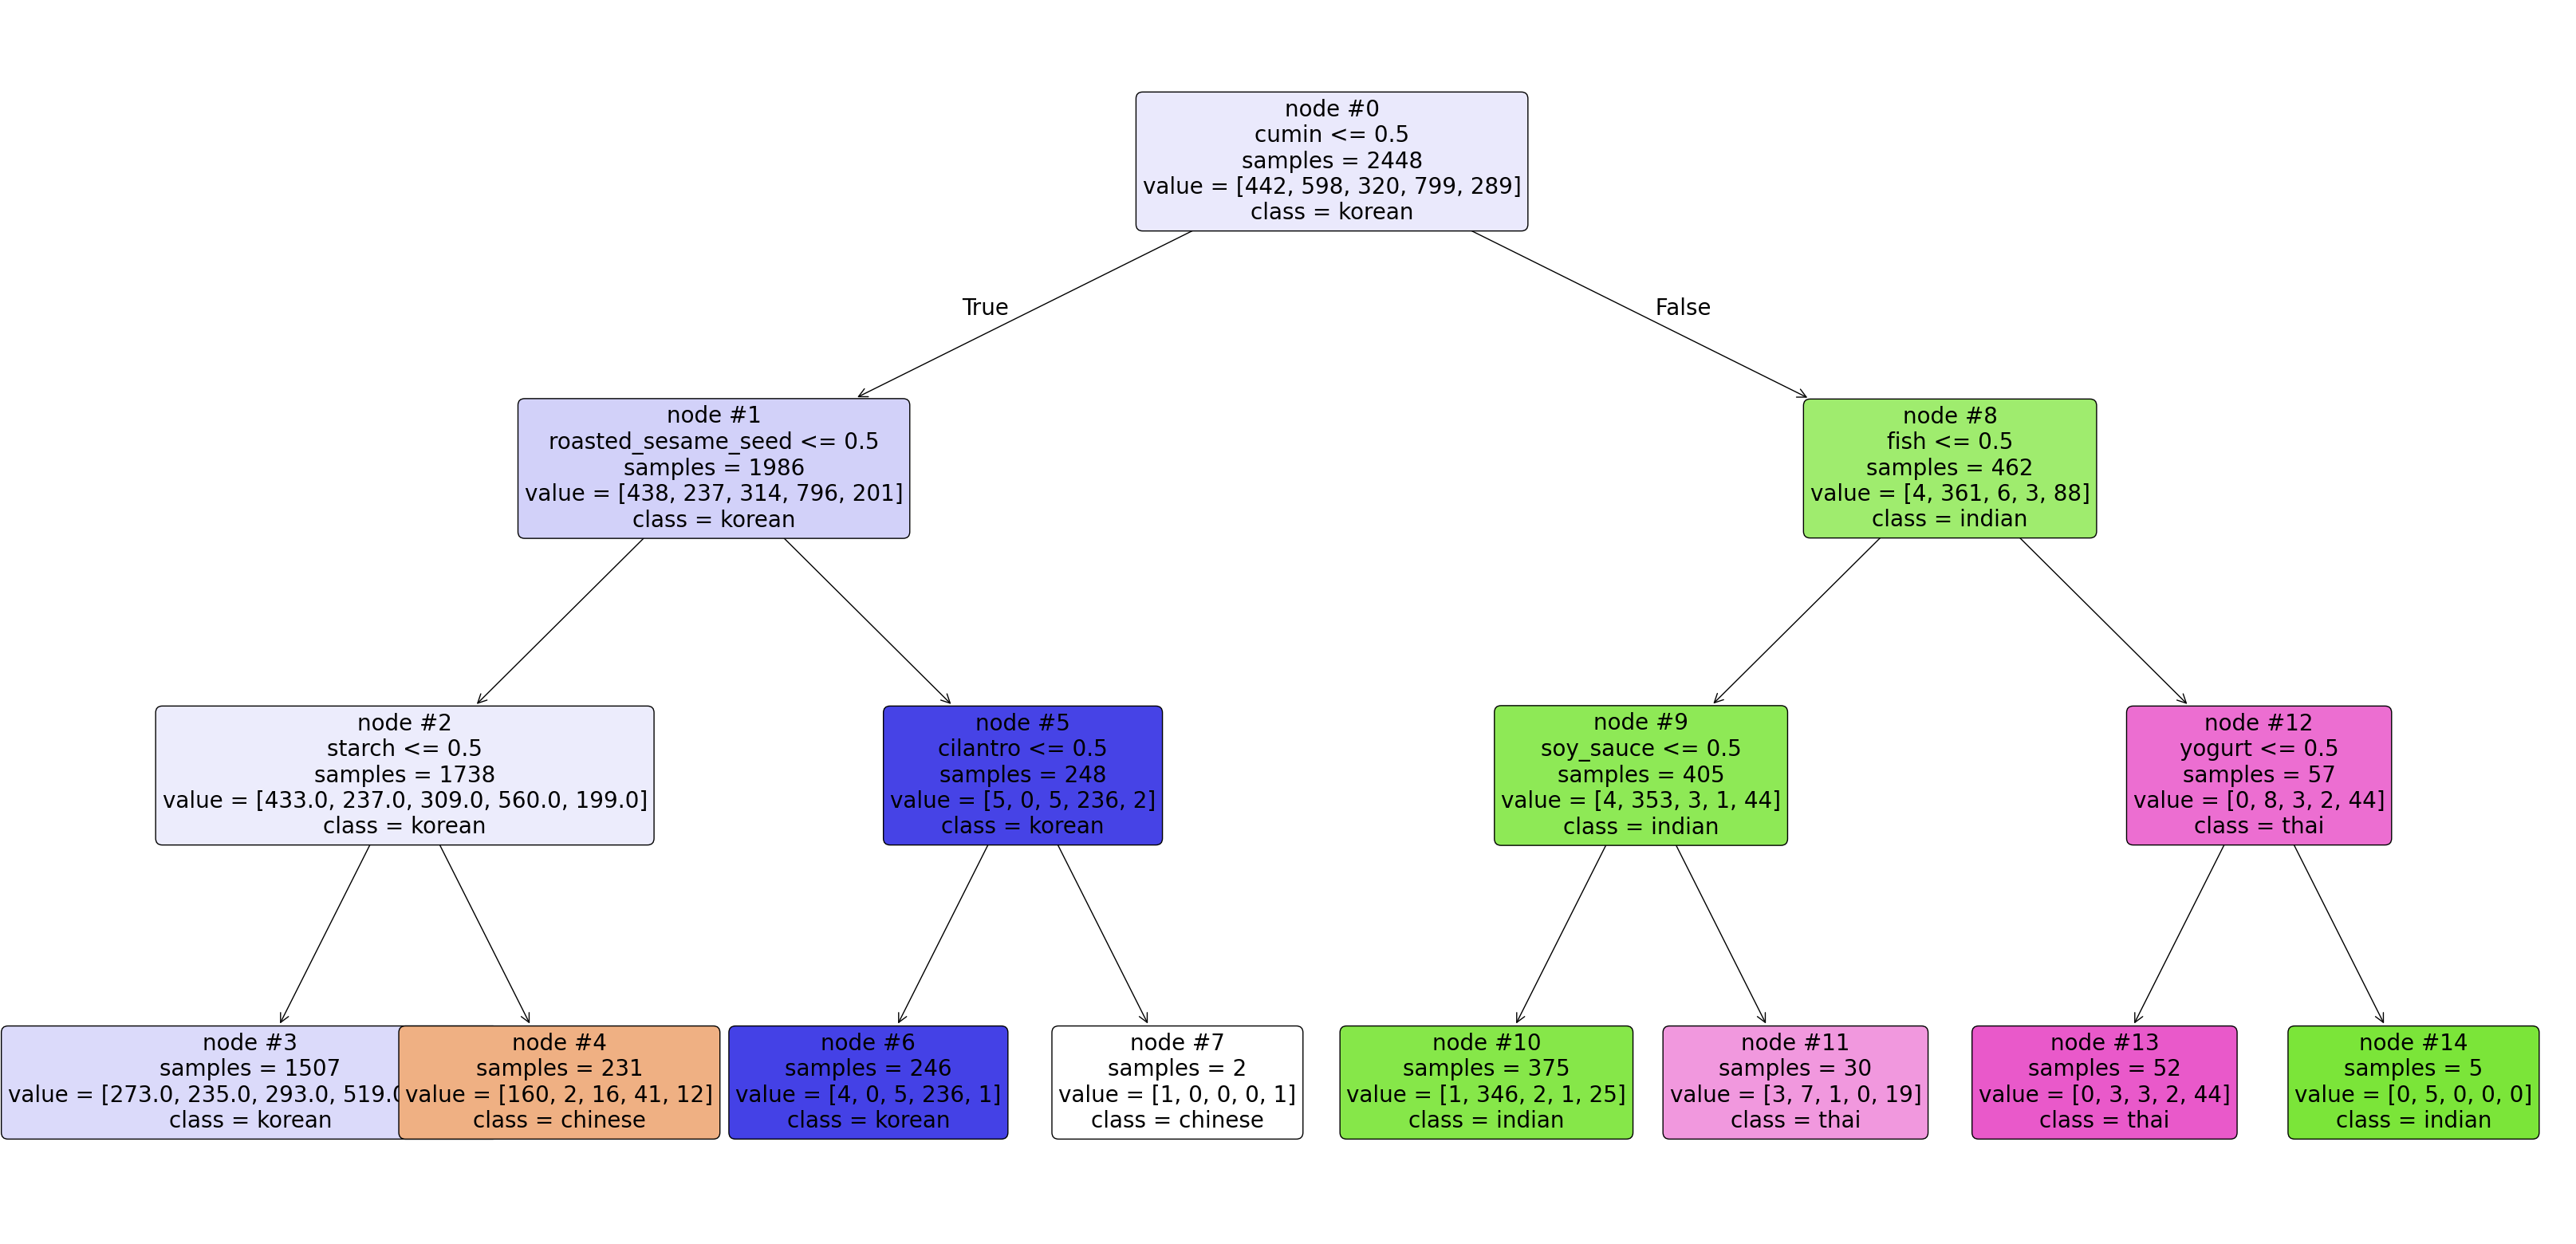

In [8]:
# if you're using the graphviz library, you can run these lines of code. Otherwise, this is configured to use plot_tree from sklearn
# export_graphviz(bamboo_tree,
#                 feature_names=list(ingredients.columns.values),
#                 out_file="bamboo_tree.dot",
#                 class_names=np.unique(cuisines),
#                 filled=True,
#                 node_ids=True,
#                 special_characters=True,
#                 impurity=False,
#                 label="all",
#                 leaves_parallel=False)

# with open("bamboo_tree.dot") as bamboo_tree_image:
#     bamboo_tree_graph = bamboo_tree_image.read()
# graphviz.Source(bamboo_tree_graph)

plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(bamboo_tree,
                   feature_names = list(ingredients.columns.values),
                   class_names=np.unique(cuisines),filled=True,
                   node_ids=True,
                   impurity=False,
                   label="all",
                   fontsize=20, rounded = True)
plt.show()

In [9]:
bamboo = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]

In [10]:
bamboo["cuisine"].value_counts()

cuisine
korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: count, dtype: int64

In [11]:
# set sample size
sample_n = 30

In [12]:
# take 30 recipes from each cuisine
random.seed(1234) # set random seed
bamboo_test = bamboo.groupby("cuisine", group_keys=False).apply(lambda x: x.sample(sample_n))

bamboo_test_ingredients = bamboo_test.iloc[:,1:] # ingredients
bamboo_test_cuisines = bamboo_test["cuisine"] # corresponding cuisines or labels

C:\Users\v0cn119\AppData\Local\Temp\ipykernel_35316\259390036.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bamboo_test = bamboo.groupby("cuisine", group_keys=False).apply(lambda x: x.sample(sample_n))


In [13]:
# check that we have 30 recipes from each cuisine
bamboo_test["cuisine"].value_counts()

cuisine
chinese     30
indian      30
japanese    30
korean      30
thai        30
Name: count, dtype: int64

In [14]:
bamboo_test_index = bamboo.index.isin(bamboo_test.index)
bamboo_train = bamboo[~bamboo_test_index]

bamboo_train_ingredients = bamboo_train.iloc[:,1:] # ingredients
bamboo_train_cuisines = bamboo_train["cuisine"] # corresponding cuisines or labels

In [15]:
bamboo_train["cuisine"].value_counts()

cuisine
korean      769
indian      568
chinese     412
japanese    290
thai        259
Name: count, dtype: int64

In [16]:
bamboo_train_tree = tree.DecisionTreeClassifier(max_depth=15)
bamboo_train_tree.fit(bamboo_train_ingredients, bamboo_train_cuisines)

print("Decision tree model saved to bamboo_train_tree!")

Decision tree model saved to bamboo_train_tree!


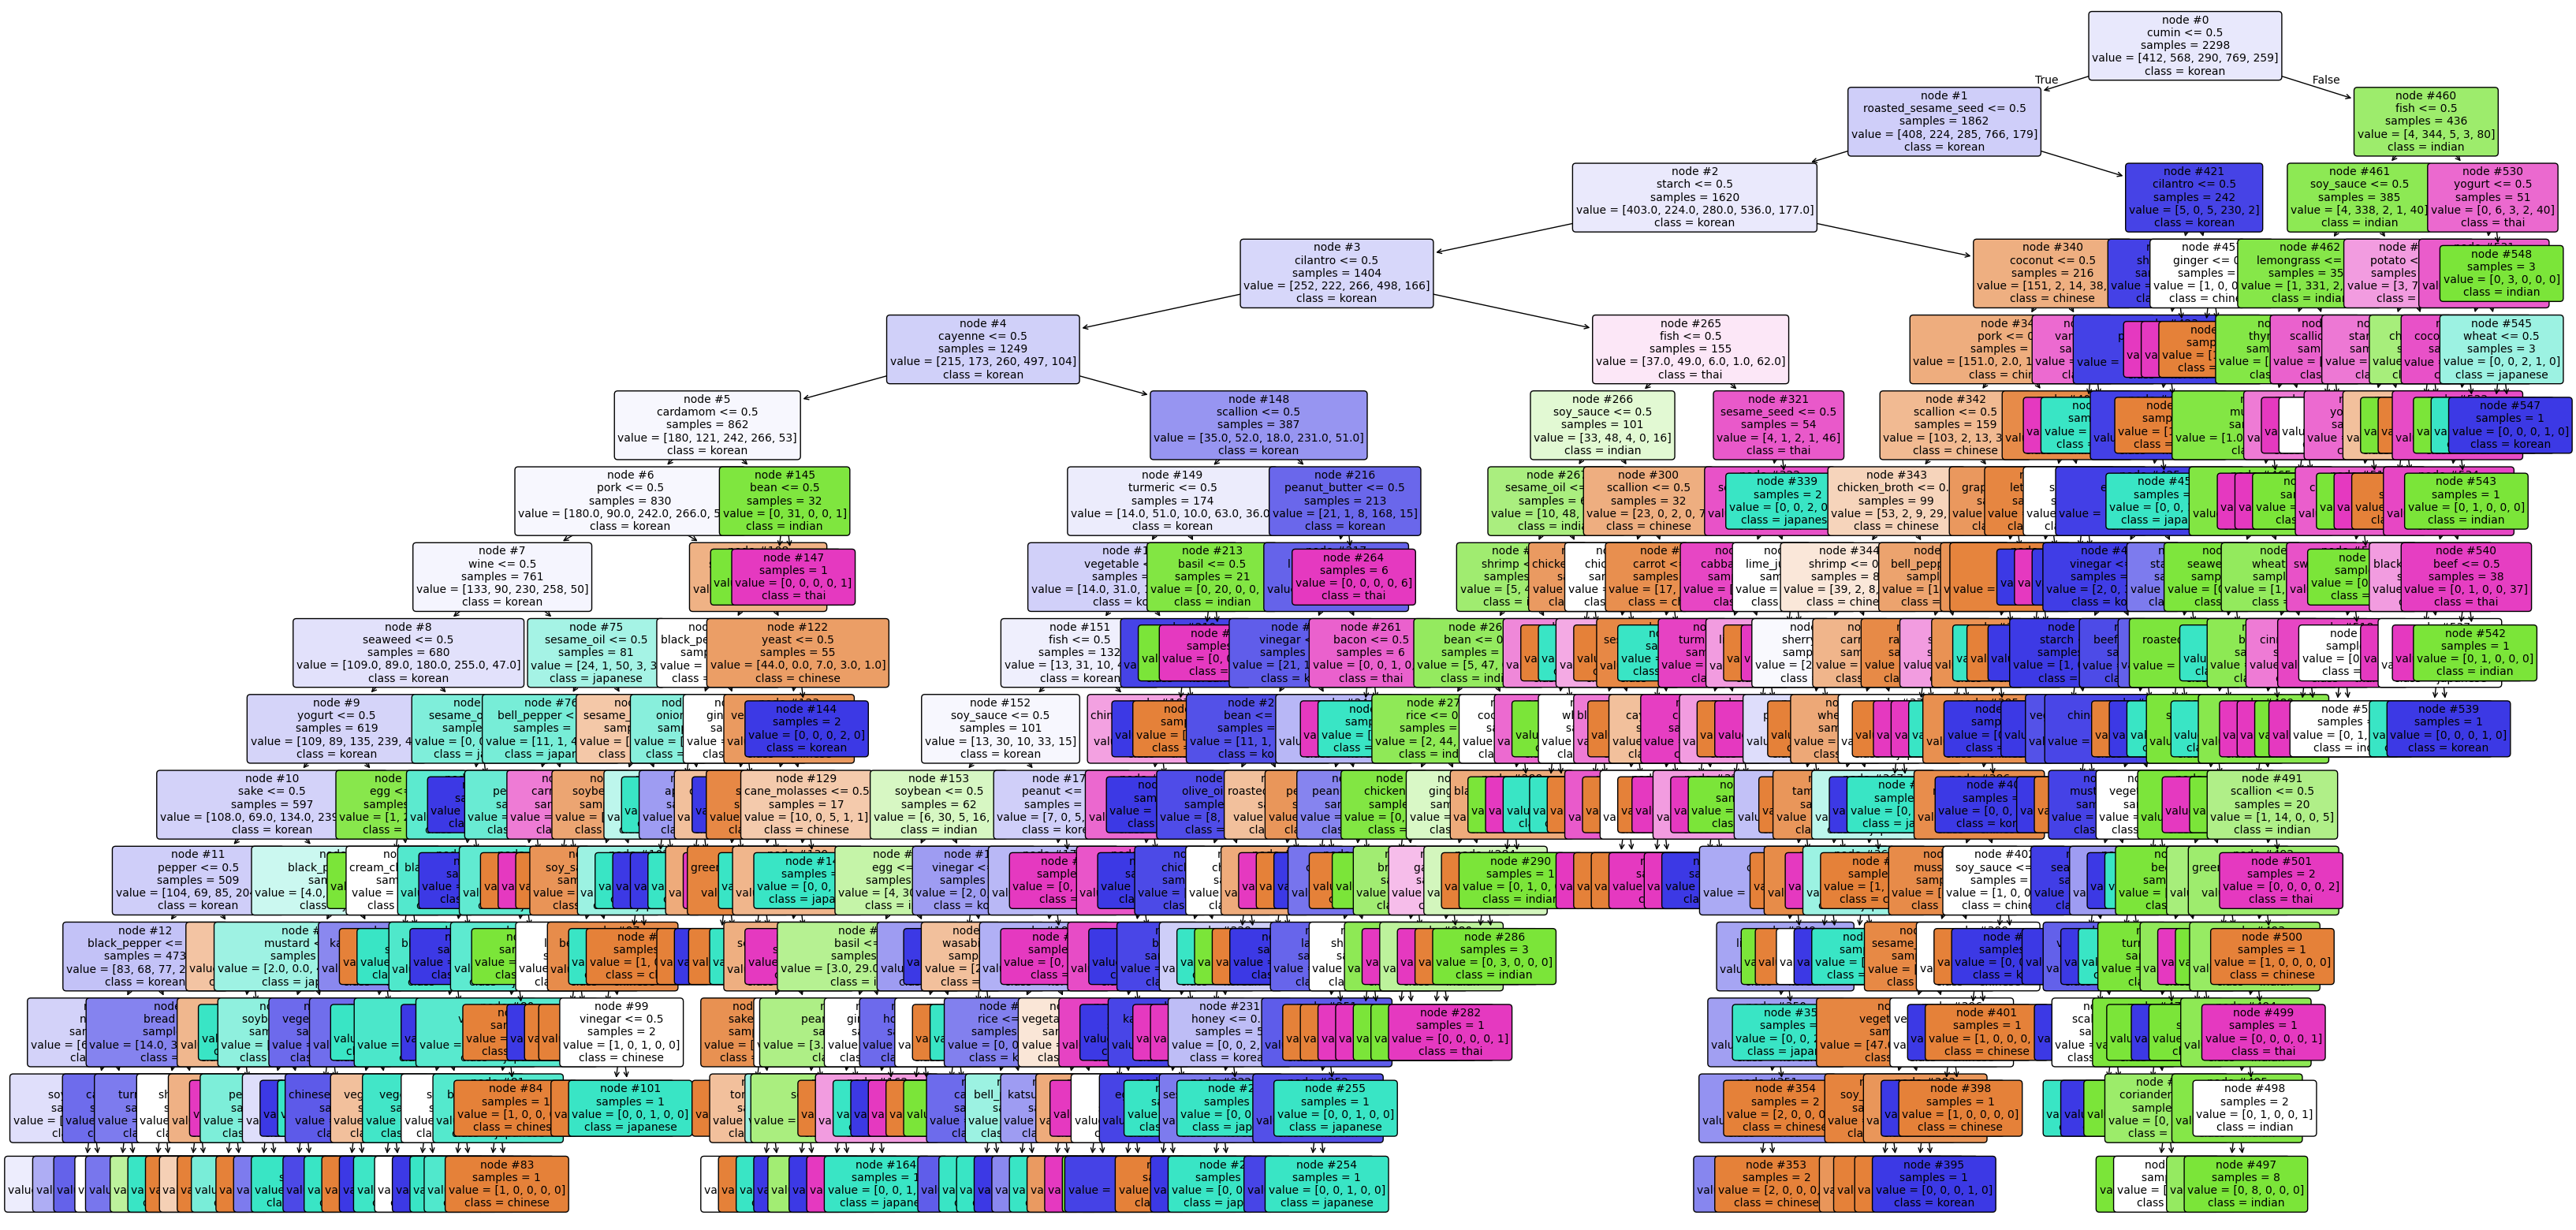

In [17]:
# export_graphviz(bamboo_train_tree,
#                 feature_names=list(bamboo_train_ingredients.columns.values),
#                 out_file="bamboo_train_tree.dot",
#                 class_names=np.unique(bamboo_train_cuisines),
#                 filled=True,
#                 node_ids=True,
#                 special_characters=True,
#                 impurity=False,
#                 label="all",
#                 leaves_parallel=False)

# with open("bamboo_train_tree.dot") as bamboo_train_tree_image:
#     bamboo_train_tree_graph = bamboo_train_tree_image.read()
# graphviz.Source(bamboo_train_tree_graph)

plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(bamboo_train_tree,
                   feature_names=list(bamboo_train_ingredients.columns.values),
                   class_names=np.unique(bamboo_train_cuisines),
                   filled=True,
                   node_ids=True,
                   impurity=False,
                   label="all",
                   fontsize=10, rounded = True)
plt.show()

In [18]:
bamboo_pred_cuisines = bamboo_train_tree.predict(bamboo_test_ingredients)

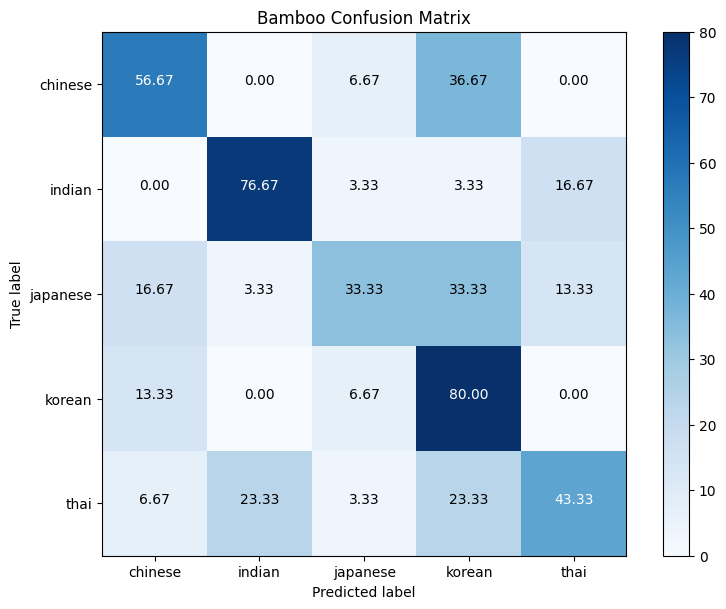

In [19]:
test_cuisines = np.unique(bamboo_test_cuisines)
bamboo_confusion_matrix = confusion_matrix(bamboo_test_cuisines, bamboo_pred_cuisines, labels = test_cuisines)
title = 'Bamboo Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
bamboo_confusion_matrix = (
    bamboo_confusion_matrix.astype('float') / bamboo_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(bamboo_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_cuisines))
plt.xticks(tick_marks, test_cuisines)
plt.yticks(tick_marks, test_cuisines)

fmt = '.2f'
thresh = bamboo_confusion_matrix.max() / 2.
for i, j in itertools.product(range(bamboo_confusion_matrix.shape[0]), range(bamboo_confusion_matrix.shape[1])):
    plt.text(j, i, format(bamboo_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if bamboo_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()